# Motivation

In the world of machine learning and data science, the logistic regression often gets disparagingly cast aside as trivial and uninteresting. To me, however, the logistic regression the "hydrogen atom" of machine learning, that is, sufficiently complex to encompass a number of interesting features, while being sufficiently simple that it is easily solved and interpreted. That makes the logistic regression extremely interesting to me as a point of study.

Moreover, in practice, the logistic model comes up a lot, at least in my work. Part of the reason for that comes from its ease of interpretation. In health outcomes research, interpretability is extremely valueable. 

However, despite its simplicity, there are actually a few subtleties about how to use the logistic regression properly. With subtlety comes often misunderstanding, and since I find the same misunderstandings coming up over and over again, I thought it would be useful to write a little tutorial dispelling some of these commonly held misconceptions. 

This lesson is part one. When does a logistic regression model fail to converge? What can we do about it?

In [14]:
import numpy as np
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from dataclasses import dataclass
from typing import List

In [87]:
def compute_logit(x: np.array, beta: np.array) -> np.array:
    
    if len(x.shape) == 1:
        x = np.reshape(x, (1,) + x.shape)
        
    assert len(beta) == x.shape[0] + 1
    
    logit = beta[0] + np.dot(beta[1:], x)
    return logit
    
def compute_logistic_probalities(x: np.array, beta: np.array) -> np.array:
    
    logit = compute_logit(x, beta)
    p = 1./ (1 + np.exp(-logit))

    return p

def sample_logistic_model(x: np.array, beta: np.array) -> np.array:
    
    p = compute_logistic_probalities(x, beta)
    y = (np.random.rand(len(p)) < p).astype(int)
    return y


def compute_log_likelihood(x: np.array, y: np.array, beta: np.array, C:float) -> np.array:
    
    logit = compute_logit(x, beta)
    log_likelihood = (logit * y).sum() - np.log(1 + np.exp(logit)).sum() - C * (np.array(beta)**2).sum()
    return log_likelihood
    
    

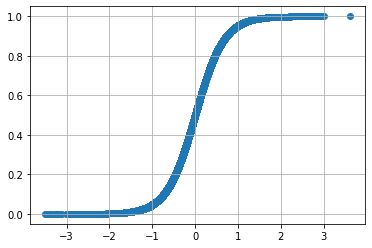

In [88]:
N = 10000
beta_true = [0, 3]
x = np.random.randn(N)
p = compute_logistic_probalities(x, beta_true)
plt.scatter(x, p)
plt.grid()

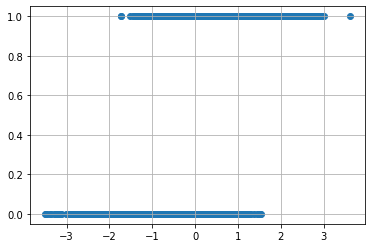

In [89]:
y = sample_logistic_model(x, beta_true)
plt.scatter(x, y)
plt.grid()

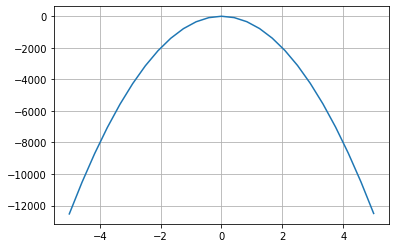

In [99]:
beta1 = 0
beta2 = np.linspace(-5, 5, 25)

ll = [compute_log_likelihood(x, y, [beta1, b2], C=500) for b2 in beta2]
plt.plot(beta2, ll)
plt.grid()

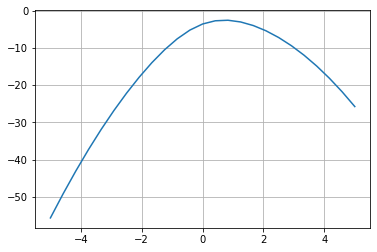

In [101]:
x = np.array([-2, -1, 0, 1, 2])
y = np.array([0, 0, 0, 1, 1])

ll = [compute_log_likelihood(x, y, [beta1, b2], C=1) for b2 in beta2]
plt.plot(beta2, ll)
plt.grid()

In [221]:
def generate_patient_features(n_patients: int=100) -> pd.DataFrame:
    
    p_comorbidity = [0.3, 0.5]
    p_comedication = [0.2, 0.4]
    comorbidities = (np.random.rand(n_patients, len(p_comorbidity)) > p_comorbidity).astype(float)
    comedications = (np.random.rand(n_patients, len(p_comedication)) > p_comedication).astype(float)

    p_insurance = [0.2, 0.4, 0.05, 0.1, 0.25]
    insurance_types = list('ABCDE')
    insurances = np.expand_dims(np.random.choice(insurance_types, size=n_patients, replace=True, p=p_insurance), -1)

    features = np.hstack((comorbidities, comedications, insurances))
    columns = [f'comor_{j+1}' for j in range(len(p_comorbidity))] + \
        [f'comed_{j+1}' for j in range(len(p_comedication))] + \
        ['insurance_type']
    
    return pd.DataFrame.from_records(features, columns=columns)

In [232]:
df = generate_patient_features(10000)
df

,comor_1,comor_2,comed_1,comed_2,insurance_type
0,1.0,0.0,1.0,1.0,E
1,1.0,0.0,1.0,0.0,A
2,1.0,1.0,1.0,0.0,E
3,1.0,1.0,1.0,0.0,E
4,0.0,0.0,0.0,1.0,D
...,...,...,...,...,...
9995,0.0,1.0,1.0,1.0,E
9996,1.0,0.0,1.0,1.0,B
9997,0.0,0.0,1.0,0.0,D
9998,1.0,0.0,1.0,1.0,B


In [233]:
df_dummy = pd.get_dummies(df[['insurance_type']])
df.loc[:, df_dummy.columns] = df_dummy.values
del df['insurance_type']
df.loc[:, df.columns] = df.values.astype(float)
df

,comor_1,comor_2,comed_1,comed_2,insurance_type_A,insurance_type_B,insurance_type_C,insurance_type_D,insurance_type_E
0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
9995,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
9996,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
9997,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
9998,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0


In [250]:
beta = np.array([0.1, 0.2, 0.1, 0.3, 1, -0.2, -3, 2, 0.2, 1, 0.3])[:len(df.columns)+1]
y = sample_logistic_model(df.values.T, beta)

df.loc[:, 'comor_3'] = 1
df.loc[y == 0, 'comor_3'] = 0#df['comor_1'][y == 0]
df.loc[y == 1, 'comor_3'] = 1


In [251]:
import copy
df2 = copy.deepcopy(df)
df2.loc[:, 'y']  = y
df2.groupby(['comor_3', 'y']).count()

,,comor_1,comor_2,comed_1,comed_2,insurance_type_A,insurance_type_B,insurance_type_C,insurance_type_D,insurance_type_E
comor_3,y,,,,,,,,,
0,0,4208,4208,4208,4208,4208,4208,4208,4208,4208
1,1,5792,5792,5792,5792,5792,5792,5792,5792,5792


In [255]:
clf = LogisticRegression(C=100000, verbose=1, max_iter=10000)
clf.fit(df.values, y)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D+03    |proj g|=  2.89600D+03

           * * *



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


LogisticRegression(C=100000, max_iter=10000, verbose=1)

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     26     27      1     0     0   9.146D-05   6.085D-03
  F =   6.0847463201243309E-003

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [256]:
print(f'{beta[0]:.2f}\t{clf.intercept_[0]:.2f}')
for j, b in enumerate(beta[1:]):
    print(f'{b:.2f}\t{clf.coef_[0][j]:.2f}')

0.10	-12.72
0.20	-0.17
0.10	-0.14
0.30	-0.37
1.00	0.25
-0.20	-2.51
-3.00	-3.86
2.00	-1.20
0.20	-2.22
1.00	-1.90
0.30	32.52


In [193]:
# from sklearn.datasets import load_breast_cancer
# load_breast_cancer(as_frame=True)['data']

In [209]:
!pip install git+https://github.com/IBM/causallib.git 

  Cloning https://github.com/IBM/causallib.git to /private/var/folders/v1/k6h5vknx3cj8qf196kq8rrvm0000gq/T/pip-req-build-gpb48kug
  Running command git clone --filter=blob:none --quiet https://github.com/IBM/causallib.git /private/var/folders/v1/k6h5vknx3cj8qf196kq8rrvm0000gq/T/pip-req-build-gpb48kug
  fatal: unable to access 'https://github.com/IBM/causallib.git/': Failed to connect to 10.185.190.100 port 8080 after 75005 ms: Operation timed out
  error: subprocess-exited-with-error
  
  × git clone --filter=blob:none --quiet https://github.com/IBM/causallib.git /private/var/folders/v1/k6h5vknx3cj8qf196kq8rrvm0000gq/T/pip-req-build-gpb48kug did not run successfully.
  │ exit code: 128
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: subprocess-exited-with-error

× git clone --filter=blob:none --quiet https://github.com/IBM/causallib.git /private/var/folders/v1/k6h5vknx3cj8qf196kq8rrvm0000gq/T/pip-req-build-gpb

In [210]:
from causallib.datasets.data_loader import load_acic16, load_data_file

ModuleNotFoundError: No module named 'causallib'

In [ ]:
datasets = {}
for i in range(1, 11):
    data = load_acic16(i)
    X = data['X']
    a = data['a']
    X.loc[:, 'population'] = 'pop_' + a.astype(str)
    X.loc[:, 'patient_id'] = list(range(len(X)))
    X.to_csv(f'acic16_competition_{i:02d}.csv', index=False)
    outcomes = pd.concat([data['a'], data['y'], data['po']], axis=1)
    outcomes.columns = ['z', 'y', 'y0', 'y1']
    datasets[i] = {'X':X, 'a':a, 'outcome':outcomes}
X.head()